# Exploring The Causes of SAT Performance in NYC Public Schools

The quality of education and causes of disparity in public school performance has always been a top priority of parents, education administrators, and elected offcials.  New York City is home to the largest public school system in the United States with over 1 million students and a budget of over $30 billion.  Here we will look at various demographic metrics and evaluate their impact on SAT scores.  

The Scholastic Aptitude Test or SAT is a nationally standarized test that higher education institutions use in their admission decisions.  It consists of 3 parts: each has a maximum of 800 points for a maximum of 2400.  The SAT is often used as a measure of a school's overall quality.  

We will be using data from published by the City of New York through its "Open Data" portal:

[Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Average class size for each school

[AP Exam Results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e) - School level AP exam results

[Graduation Outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a) - Graduation outcomes for each school

[Demographics Information](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j) - Demographic data for each school

[SAT Results](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) - SAT scores for each high school

[Attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt) - Attendance and enrollment statistics

[School Surveys](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) - Yearly parent, teacher, and student survey at each school

## Read In The Data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import folium
import re


%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

# Store all dataframes in a dictionary for easy reference
data = {}
for f in data_files:
    d = pd.read_csv("{0}".format(f))
    key_name = f.replace(".csv", "")
    data[key_name] = d

In [2]:
data.keys()

dict_keys(['ap_2010', 'class_size', 'demographics', 'graduation', 'hs_directory', 'sat_results'])

### Observations:

- Each school entry has an unique DBN number or the relevant information needed to compile one
- We can ultimately join the data sets based on this number
- The SAT scores are divied into the three sections which we can combine into the total score
- Some of the schools have multiple rows so we will have to  do some processing to ensure that each DBN is unique

## Read In The Survey Data

In [3]:
all_survey = pd.read_csv("survey_all.txt", delimiter="\t", encoding="windows-1252")
d75_survey = pd.read_csv("survey_d75.txt", delimiter="\t", encoding="windows-1252")

# Create a dataframe with the combined surveys
survey = pd.concat([all_survey, d75_survey], axis=0)

In [4]:
# Make "DBN" lowercase
survey["DBN"] = survey["dbn"]

# Keep only the relevent columns that will give us data about how students and parents feel about
# school safety, academic performance, as well as the DBN
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey[survey_fields]
data["survey"] = survey

## Cleaning and Combining the Data

### Adding a ```DBN``` column to ```class_size```

Although ```class_size``` does not have a ```DBN``` column, we can create one using the ```CSD``` and ```School Code``` columns:

In [5]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN


In [6]:
data['sat_results']['DBN'].head()

0    01M292
1    01M448
2    01M450
3    01M458
4    01M509
Name: DBN, dtype: object

In [7]:
# Cast to 'str' and add a '0' in pad the number so that single digits contain a leading '0'

# Define function to be used in .apply()
def dbn_func(n):
   return str(n).zfill(2)

# Create new 'padded_csd' column
data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(dbn_func)

# Join 'padded_csd' and 'SCHOOL CODE' into new 'DBN' column
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']

In [8]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


##  Combine SAT Section Scores Into One Total Score

The SAT scores are currently presented in each of the three test sections.  We want to combine them into one column for easier analysis.

In [9]:
# Convert each column to a numeric data type
data['sat_results']['SAT Math Avg. Score'] = pd.to_numeric(data['sat_results']['SAT Math Avg. Score'], errors="coerce")
data['sat_results']['SAT Critical Reading Avg. Score'] = pd.to_numeric(data['sat_results']['SAT Critical Reading Avg. Score'], errors="coerce")
data['sat_results']['SAT Writing Avg. Score'] = pd.to_numeric(data['sat_results']['SAT Writing Avg. Score'], errors="coerce")

# Add them together into a new column
data['sat_results']['sat_score'] = data['sat_results']['SAT Math Avg. Score'] + data['sat_results']['SAT Critical Reading Avg. Score'] + data['sat_results']['SAT Writing Avg. Score']

data['sat_results']['sat_score'].head()

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64

### Extracting Geographic Location Data

In [10]:
data['hs_directory']['Location 1'].value_counts()

3000 East Tremont Avenue\nBronx, NY 10461\n(40.840513977000455, -73.83812095999963)       6
800 East Gun Hill Road\nBronx, NY 10467\n(40.87575421100047, -73.86138783399963)          6
500 East Fordham Road\nBronx, NY 10458\n(40.86001222100049, -73.88822960399966)           6
122 Amsterdam Avenue\nNew York, NY 10023\n(40.77429641100048, -73.98482270099964)         6
240 East 172 Street\nBronx, NY 10457\n(40.84037339800045, -73.91083800799964)             6
                                                                                         ..
23-15 Newtown Avenue\nAstoria, NY 11102\n(40.77125089600048, -73.92460167099966)          1
227-243 West 61St Street\nNew York, NY 10023\n(40.772158119000494, -73.98779653499963)    1
29 Ft Greene Place\nBrooklyn, NY 11217\n(40.688107423000474, -73.97674507199963)          1
150-91 87 Road\nJamaica, NY 11432\n(40.70820782600049, -73.80407794599967)                1
28-01 41 Avenue\nLong Island City, NY 11101\n(40.751380834000486, -73.9374497189

In [11]:
# Define function to be used in apply
def lat_func(s):
    lat = re.findall("(?<=\()(.*)\,", s)[0]
    return lat 

# Extract latitude data and put it in a new column
data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(lat_func)

data['hs_directory']['lat'].head()

0     40.67029890700047
1      40.8276026690005
2    40.842414068000494
3     40.71067947100045
4    40.718810094000446
Name: lat, dtype: object

In [12]:
# Define function to be used in apply
def long_func(s):
    long = re.findall("(\-\d*.\d*)(?=\))", s)[0]
    return long 

# Extract latitude data and put it in a new column
data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(long_func)

data['hs_directory']['lon'].head()

0    -73.96164787599963
1    -73.90447525699966
2    -73.91616158599965
3    -74.00080702099967
4    -73.80650045499965
Name: lon, dtype: object

In [13]:
# Convert the columns to a numeric value instead of a string
data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors="coerce")
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors="coerce")

The 'class_size', 'graduation', and 'demographics' data sets have multiple rows for some of the schools, therefore multiple rows with the same DBN number.  Before we can combine the data sets, we will need to consolidate these rows into a single row.  

### Remove Duplicate ```DBN``` Data

The ```class_size``` set has multiple rows for each school for each ```GRADE``` and ```PROGRAM TYPE```. Since we are analyzing high schools, we are only interested in grades 9-12.  The ```PROGRAM TYPE``` we are inerested in is "GEN ED" 

In [14]:
class_size = data['class_size']
class_size = class_size[class_size['GRADE '] == '09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']
class_size.head(5)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292
228,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01,01M292
229,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01,01M292


We can see that there are different ```DBN``` numbers for different class subects as listed in the ```CORE SUBJECT (MS CORE and 9-12 ONLY)``` and ```CORE COURSE (MS CORE and 9-12 ONLY)```.   We can use .groupby() to split the dataframe into groups and then get the average class size using the .agg() function.

In [15]:
# Groupby 'DBN' and then aggregate by mean
class_size = class_size.groupby(by='DBN', axis=0).agg(np.mean)

# Reset index so 'DBN' becomes a column again
class_size.reset_index(inplace=True)
data['class_size'] = class_size

data['class_size'].head()

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1,57.6000,2.733333,21.200000,19.40,22.866667,NaN


For each ```DBN``` number in the ```demographics``` data set, there are multiple school years.  We want the most recent data - 2012 in this case.  

In [16]:
data['demographics'].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


In [17]:
#Filter the dataframe
data['demographics'] = data['demographics'][data['demographics']['schoolyear'] ==20112012]

print(data['demographics'].head())

       DBN                                              Name  schoolyear  \
6   01M015  P.S. 015 ROBERTO CLEMENTE                           20112012   
13  01M019  P.S. 019 ASHER LEVY                                 20112012   
20  01M020  PS 020 ANNA SILVER                                  20112012   
27  01M034  PS 034 FRANKLIN D ROOSEVELT                         20112012   
35  01M063  PS 063 WILLIAM MCKINLEY                             20112012   

   fl_percent  frl_percent  total_enrollment prek    k grade1 grade2  ...  \
6         NaN         89.4               189   13   31     35     28  ...   
13        NaN         61.5               328   32   46     52     54  ...   
20        NaN         92.5               626   52  102    121     87  ...   
27        NaN         99.7               401   14   34     38     36  ...   
35        NaN         78.9               176   18   20     30     21  ...   

   black_num black_per hispanic_num hispanic_per white_num white_per male_num  \

The ```graduation``` data set also has multiple values for the ```DBN``` number.  This is due to multiple years in the ```cohort``` column and the ```Demographic``` column.  

We will take the most most recent year from the ```cohort``` column and ```Total Cohort``` from the ```Demographic``` column.  

In [18]:
# Filter the dataframe
data['graduation'] = data['graduation'][data['graduation']['Cohort']=='2006']
data['graduation'] = data['graduation'][data['graduation']['Demographic']=='Total Cohort']

print(data['graduation'].head())

     Demographic     DBN                            School Name Cohort  \
3   Total Cohort  01M292  HENRY STREET SCHOOL FOR INTERNATIONAL   2006   
10  Total Cohort  01M448    UNIVERSITY NEIGHBORHOOD HIGH SCHOOL   2006   
17  Total Cohort  01M450             EAST SIDE COMMUNITY SCHOOL   2006   
24  Total Cohort  01M509                MARTA VALLE HIGH SCHOOL   2006   
31  Total Cohort  01M515  LOWER EAST SIDE PREPARATORY HIGH SCHO   2006   

    Total Cohort Total Grads - n Total Grads - % of cohort Total Regents - n  \
3             78              43                     55.1%                36   
10           124              53                     42.7%                42   
17            90              70                     77.8%                67   
24            84              47                       56%                40   
31           193             105                     54.4%                91   

   Total Regents - % of cohort Total Regents - % of grads  ...  \
3       

We need to convert the exam scores in the ```ap_2010``` data set to numeric values.

In [19]:
# Convert 'AP Test Takers ', 'Total Exams Taken', and 'Number of Exams with scores 3 4 or 5'
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")
    
print(data["ap_2010"].dtypes)

DBN                                      object
SchoolName                               object
AP Test Takers                          float64
Total Exams Taken                       float64
Number of Exams with scores 3 4 or 5    float64
dtype: object


## Combining the Data Sets

Because our analysis is centered around SAT scores and how demographic factors impact it, we want to preserve as many rows as possile in the ```sat_results``` data set.  We will use a left merge:

In [20]:
combined = data["sat_results"]

# Left Merge
combined = combined.merge(data['ap_2010'], how='left', on='DBN')
combined = combined.merge(data['graduation'], how='left', on='DBN')
combined.shape

(479, 33)

In [21]:
# Rename column to capital letters like the other data sets
data['hs_directory'] = data['hs_directory'].rename({'dbn':'DBN'}, axis=1)

# Inner Merge
combined = combined.merge(data['class_size'], how='inner', on='DBN')
combined = combined.merge(data['demographics'], how='inner', on='DBN')
combined = combined.merge(data['survey'], how='inner', on='DBN')
combined = combined.merge(data['hs_directory'], how='inner', on='DBN')

### Fill missing values

In [22]:
# Fill missing values with the mean of each repective column
combined = combined.fillna(combined.mean())

# Fill any leftover missing values with zero
combined = combined.fillna(0)
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to Manhattan students or residents,Then to New York City residents,0,0,0.0,0.0,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0.0,0.0,0.0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0.0,0.0,0.0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0.0,0.0,0.0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0.0,0.0,0.0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426


To analyze by school disctrict we will need to extract it from the ```DBN``` column.  The school district is the first two characters of the ```DBN``` number

In [23]:
# Define function to be used in .apply()
def first_two(s):
    dist = s[0:2]
    return dist

# Create new 'school_dist' column using .apply()
combined['school_dist'] = combined['DBN'].apply(first_two)

combined['school_dist'].head()

0    01
1    01
2    01
3    01
4    01
Name: school_dist, dtype: object

## What Is Driving SAT Score?

To answer this we will use the Pearson Correlation Coefficient or R Value.  The R value measures the correlation between two values and assigns it a valule of -1 (perfect negative correlation) to 1 (perfect positive correlation).  Zero represents no correlation at all.  

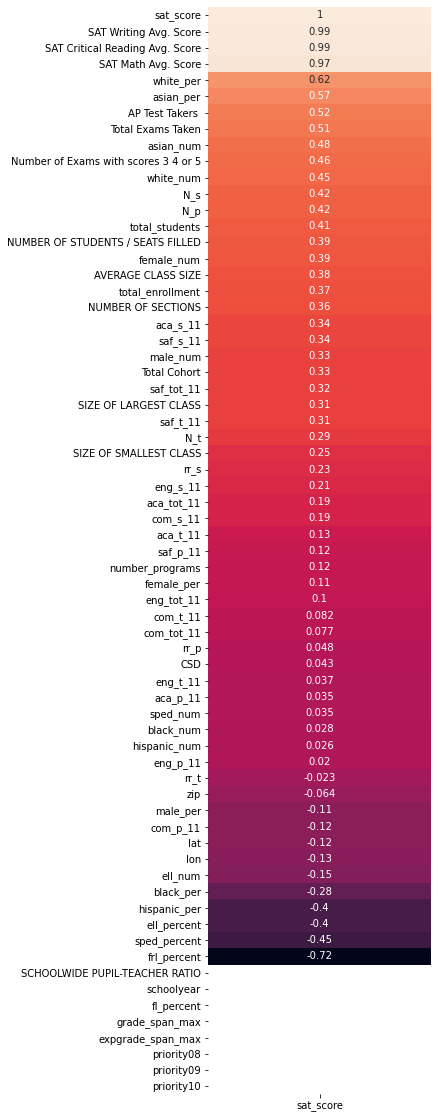

In [24]:
# Create data set that contains just the 'sat_score' column, sorted.
combined_corr = combined.corr().loc[:,['sat_score']].sort_values(by='sat_score', ascending=False)

# Adjust figure size so its long enough for our data set.
plt.figure(figsize=(4,20))

#plot
ax=sns.heatmap(combined_corr, annot = True, cbar=False)

### Observations:

- ```total_enrollment```  and ```AVERAGE CLASS SIZE``` have a positive correlation to ```sat_score```.  One might expect that smaller schools and smaller classes would result in more academic proficiency but here the opposite is true. 
- ```female_per``` and ```female_num``` correlate positively while ```male_per``` and ```male_num``` correlate negatively, however the relationships are quite weak.
- Teacher and student ratings of school safety (```saf_t_11```, and ```saf_s_11```) correlate positively
- Student ratings of academic standards (```aca_s_11```) correlate positively while academic standard ratings from teachers and parents have much less correlation
- There is racial inequality:  ```white_per```& ```asian_per``` correlate positively while ```black_per``` & ```hispanic_per``` correlate negativley
- The percentage of English language learners at the school (```ell_percent``` & ```frl_percent```) has a strong negative correlation.

 

## Total Enrollment v. SAT Score

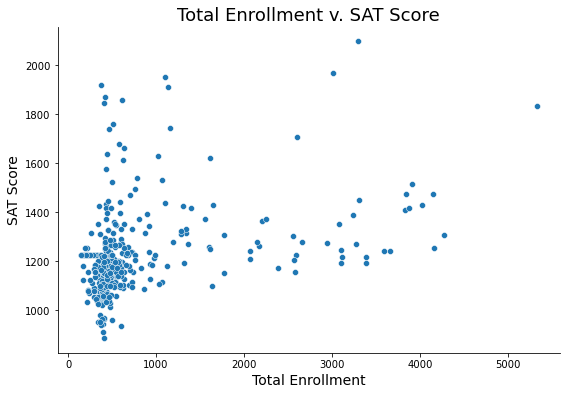

In [25]:
# Plot
fig, ax = plt.subplots(figsize=(9, 6))
ax = sns.scatterplot(data=combined, x='total_enrollment', y='sat_score')

# Plot Aesthetics
ax.set_title('Total Enrollment v. SAT Score', fontsize=18)
ax.set_xlabel('Total Enrollment', fontsize=14)
ax.set_ylabel('SAT Score', fontsize=14)
sns.despine()

There is a cluster of schools at the bottom left where both total enrollment and SAT scores are very low which could be skewing the data and r value.  

In [26]:
# Filter to view schools with low enrollment and low SAT score
low_enrollment = combined[combined['total_enrollment'] < 1000] 
low_enrollment = combined[combined['sat_score'] < 1000] 

# View the school names and percentage of English learners
low_enrollment.loc[:,['SCHOOL NAME', 'ell_percent']]

,SCHOOL NAME,ell_percent
91,INTERNATIONAL COMMUNITY HIGH SCHOOL,90.1
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,86.6
126,BRONX INTERNATIONAL HIGH SCHOOL,87.1
139,KINGSBRIDGE INTERNATIONAL HIGH SCHOOL,88.7
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,79.9
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,92.9
179,HIGH SCHOOL OF WORLD CULTURES,86.4
188,BROOKLYN INTERNATIONAL HIGH SCHOOL,83.1
225,INTERNATIONAL HIGH SCHOOL AT PROSPECT HEIGHTS,91.0
237,IT TAKES A VILLAGE ACADEMY,30.4


In [27]:
# City-wide average of ELL students
combined['ell_percent'].mean()

13.334986225895316

### Observations

The schools which have very low enrollment as well as low SAT scores are international schools where the percentage students who are English Language Learners is very high relative to the city-wide average.  

In this case it is actually ```ell_percent_y``` which correlates more closely with ```sat_score``` rather than ```total_enrollment_x```.  

Let's plot out this relationship:

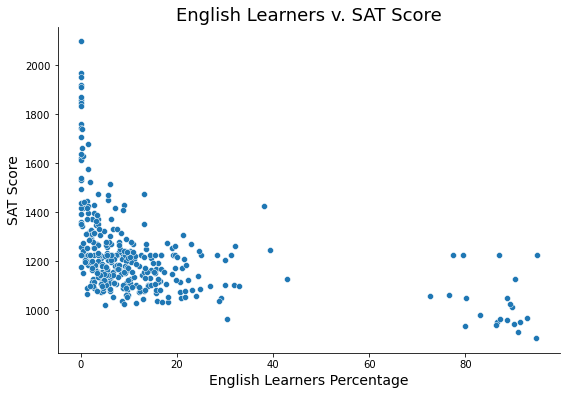

In [28]:
# Plot
fig, ax = plt.subplots(figsize=(9, 6))
ax = sns.scatterplot(data=combined, x='ell_percent', y='sat_score')

# Plot Aesthetics
ax.set_title('English Learners v. SAT Score', fontsize=18)
ax.set_xlabel('English Learners Percentage', fontsize=14)
ax.set_ylabel('SAT Score', fontsize=14)
sns.despine()

## School Districts v. SAT Score

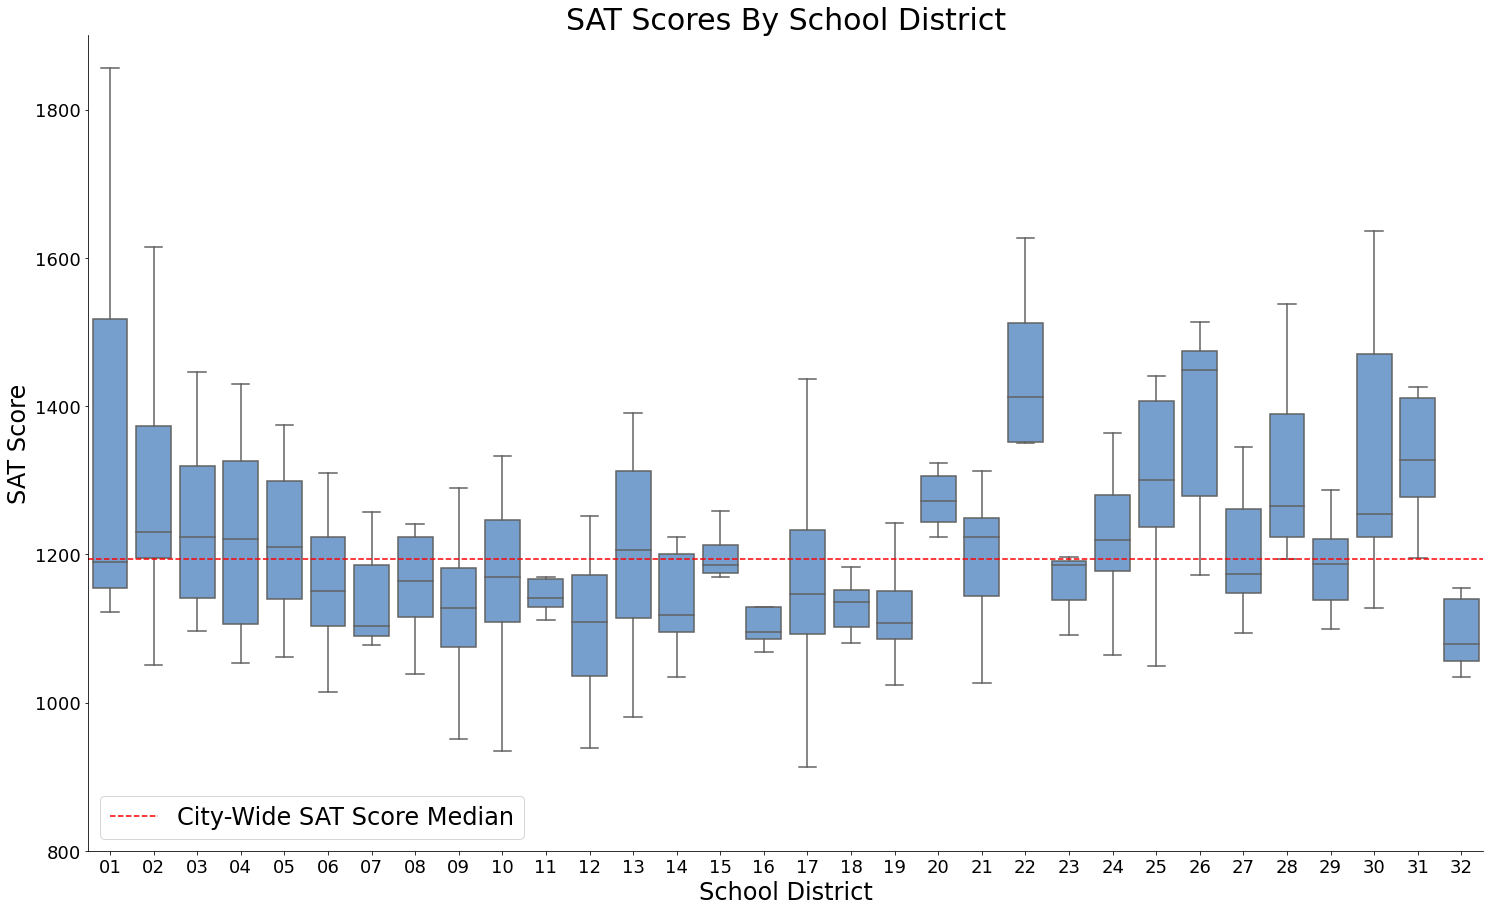

In [29]:
# Assign SAT score median for use in boxplot
sat_median = combined['sat_score'].median()

# Plot 
fig, ax = plt.subplots(figsize=(25, 15))
ax = sns.boxplot(x="school_dist", y="sat_score", data=combined,fliersize=0, color=[105/255, 158/255, 219/255])

# Plot Asethetics
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_ylabel('SAT Score', fontsize=24)
ax.set_xlabel('School District', fontsize=24)
ax.set_title('SAT Scores By School District', fontsize=30)
ax.set(ylim=(800, 1900))
ax.axhline(y=sat_median, color='red', label='City-Wide SAT Score Median', linestyle='--')
ax.legend(prop={'size': 24})
sns.despine()

### Observations

We don't see a very wide median variance between each school district.  All the districts fall within about 20% of the median.  District 22 (Southeastern Brooklyn) and 26 (Bayside, Queens) have highest SAT scores while district 32 (Bushwick, Brooklyn) has the lowest. 

## Where Are Schools With Highest SAT Scores?

Let's plot out a map of schools with SAT scores in the top 10%

In [30]:
# Filter data set to include only schools with SAT scores in the top 10%
top_sat = combined.loc[:,['sat_score', 'SCHOOL NAME', 'lat', 'lon']]
top_sat = top_sat[top_sat['sat_score'] >= top_sat['sat_score'].quantile(q=0.9)]
top_sat.head()

,sat_score,SCHOOL NAME,lat,lon
4,1621.0,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",40.718725,-73.979426
5,1856.0,BARD HIGH SCHOOL EARLY COLLEGE,40.718962,-73.976066
17,1435.0,NYC ISCHOOL,40.724353,-74.004759
22,1522.0,PROFESSIONAL PERFORMING ARTS HIGH SCHOOL,40.761433,-73.988024
23,1577.0,BARUCH COLLEGE CAMPUS HIGH SCHOOL,40.744047,-73.991479


In [31]:
# Create Empty Map
top_sat_map = folium.Map(location=[40.708, -73.94],
                        zoom_start=10.5,
                        tiles="CartoDB positron")

# Add 'markers' to pin the schools in our ```safest``` dataframe
for i in range(0,len(top_sat)):
    folium.Marker([top_sat.iloc[i]['lat'], top_sat.iloc[i]['lon']], popup=top_sat.iloc[i]['SCHOOL NAME']).add_to(top_sat_map)
top_sat_map

## Examining Survey Fields with SAT Score

Recall that we combined the ```all_survey``` and ```d75_survey``` data sets into a single data set called ```survey```.  These surveys contained responses from parents, teachers, and students on issues such as engagement, safety, and communication.   

Recall the data dictionary (Note: While this reference is from 2010, the descriptions are the same for our 2011 data set):

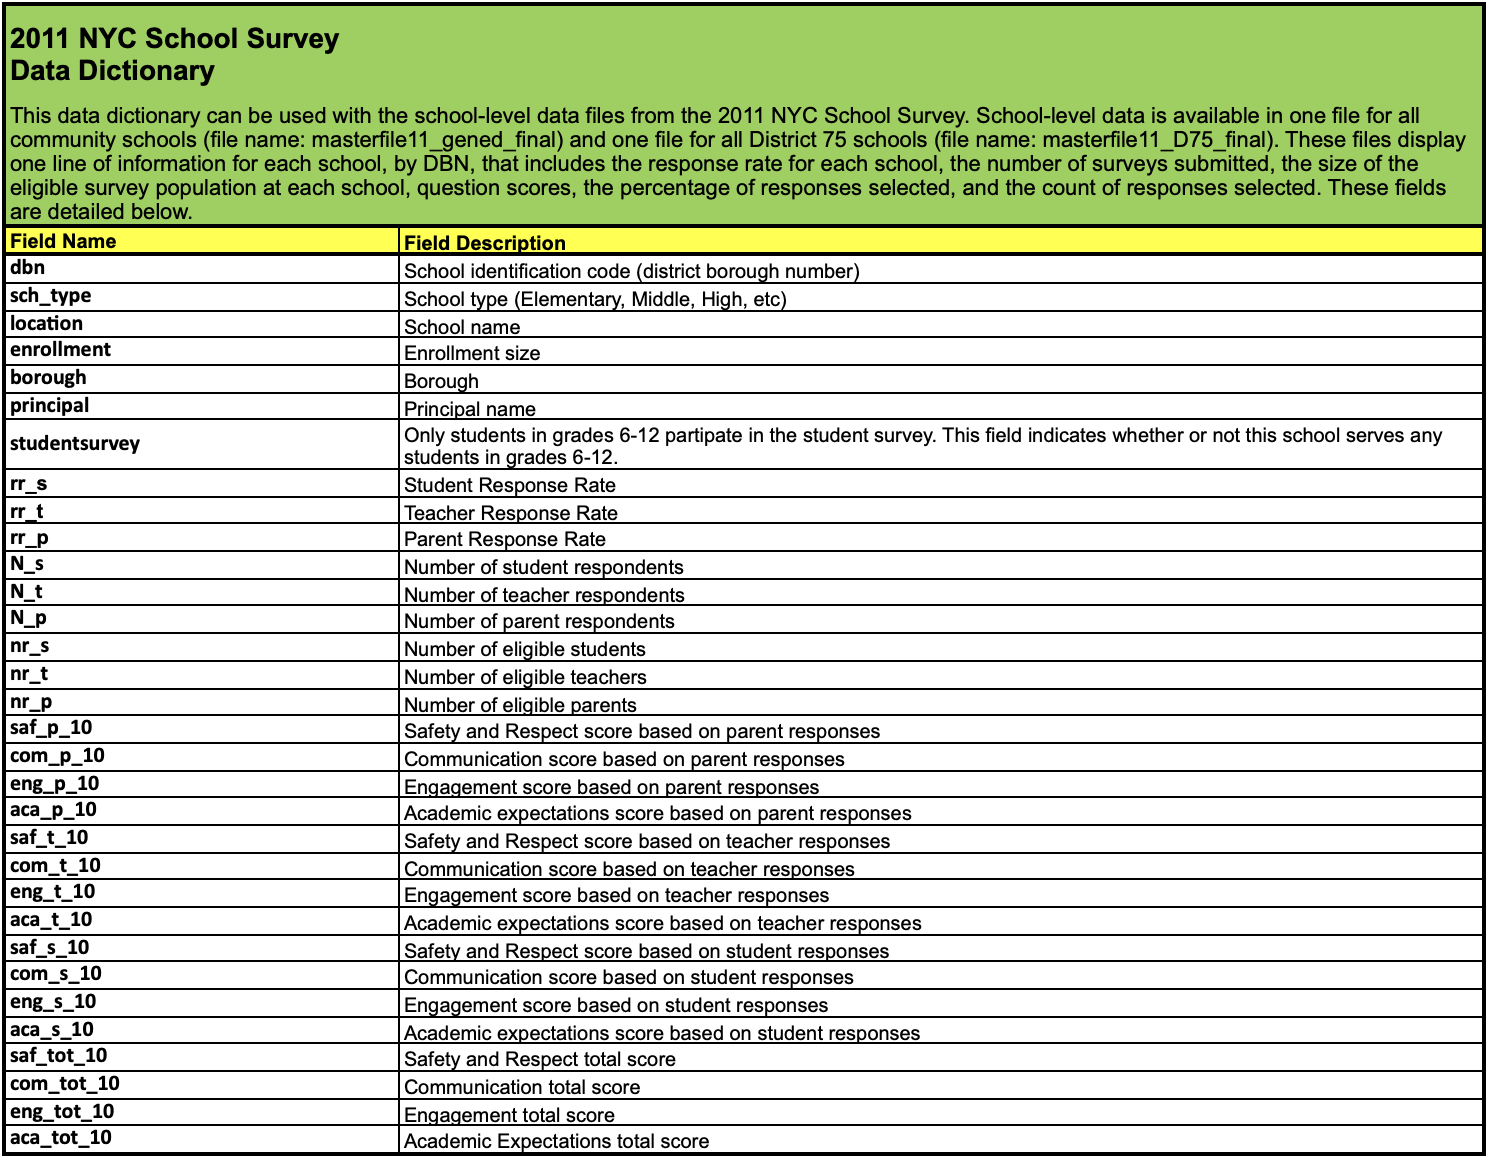

In [32]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

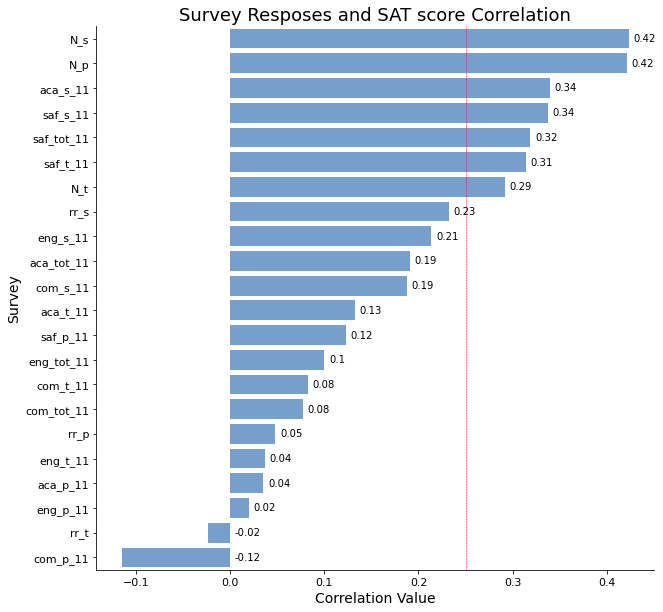

In [33]:
correlations = combined.corr()
correlations = correlations['sat_score']
correlations_survey = correlations[survey_fields].sort_values(ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
ax=sns.barplot(x='sat_score', y='index', data=correlations_survey.reset_index(), color=[105/255, 158/255, 219/255])

# Plot Aesthetics
ax.axvline(x=0.25,color='red',linestyle='dashed',linewidth=0.5)
ax.set_title('Survey Resposes and SAT score Correlation', fontsize=18)
ax.set_ylabel('Survey', fontsize=14)
ax.set_xlabel('Correlation Value', fontsize=14)
ax.tick_params(labelsize=11)
sns.despine()

# Bar Labels
for p in ax.patches:
    width = p.get_width()
    x, y = p.get_xy()
    ax.annotate(str(round(width, 2)),(max(width, 0) + 0.005, y + 0.5))

### Observations

```N_s```, ```N_t```, & ```N_p``` are proxies for ```total_enrollment```, it is expected that they would be high as well.  

The safety scores ```saf_s_11```, ```saf_tot_11```, and ```saf_t_11``` are highly correlated with SAT scores, however the parents' safety score (```saf_p_11```) is much less correlated.  This could be that the students and teachers are present at school every day and have first hand impressions of safety at the school, while the parents are more removed from the daily experience.

The student reported academic score ```aca_s_11``` is highly correlated.  This might mean that if the students are being challenged academically, then it makes sense that they would tend to do well on the SAT.  Interestingly, the parents' nor teachers' perception of academic standards have much correlation.  

```rr_s``` is moderately correlated;  if a student cares enought to fill out the survey, then it might be a sign that they they take school seriously and will do well on the SAT.   

## Safer Schools Mean Higher SAT Scores

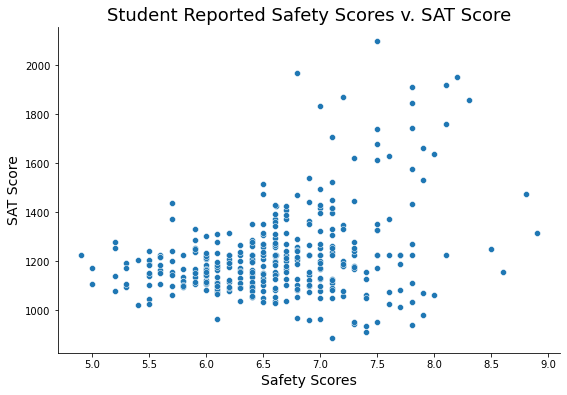

In [34]:
# Plot
fig, ax = plt.subplots(figsize=(9, 6))
ax = sns.scatterplot(data=combined, x='saf_s_11', y='sat_score')

# Plot Aesthetics
ax.set_title('Student Reported Safety Scores v. SAT Score', fontsize=18)
ax.set_xlabel('Safety Scores', fontsize=14)
ax.set_ylabel('SAT Score', fontsize=14)
sns.despine()

### Observations

This plot confirms that as safety scores rise, SAT scores follow.  From a safety score of 5 until about 7, we see an overall increase in SAT scores.  From 7 though 8.25, we see an expansion in the upper limit of scores.  From 8.5 onwards we scores that are lower than we would have expected.  

## Where Are The Safest Schools?

Let's plot on a map where the safest schools are:

In [35]:
# Filter data set to include only schools with safety scores of 8 or greater
safest = combined[combined['saf_s_11'] >= 8]
safest = safest.loc[:, ['lat', 'lon', 'SCHOOL NAME']]
safest

,lat,lon,SCHOOL NAME
5,40.718962,-73.976066,BARD HIGH SCHOOL EARLY COLLEGE
26,40.770116,-73.953379,ELEANOR ROOSEVELT HIGH SCHOOL
155,40.871255,-73.897516,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
173,40.827764,-73.900387,BRONX LATIN
175,40.825226,-73.893950,PEACE AND DIVERSITY ACADEMY
291,40.744150,-73.933627,INTERNATIONAL HIGH SCHOOL AT LAGUARDIA COMMUNI...
305,40.740556,-73.792848,FRANCIS LEWIS HIGH SCHOOL
338,40.771251,-73.924602,"YOUNG WOMEN'S LEADERSHIP SCHOOL, ASTORIA"
346,40.755175,-73.926824,BACCALAUREATE SCHOOL FOR GLOBAL EDUCATION
356,40.567913,-74.115362,STATEN ISLAND TECHNICAL HIGH SCHOOL


In [36]:
# Create Empty Map
safe_map = folium.Map(location=[40.708, -73.94],
                        zoom_start=10.5,
                        tiles="CartoDB positron")

# Add 'markers' to pin the schools in our ```safest``` dataframe
for i in range(0,len(safest)):
    folium.Marker([safest.iloc[i]['lat'], safest.iloc[i]['lon']], popup=safest.iloc[i]['SCHOOL NAME']).add_to(safe_map)
safe_map

## Which Boroughs Have The Safest Schools?

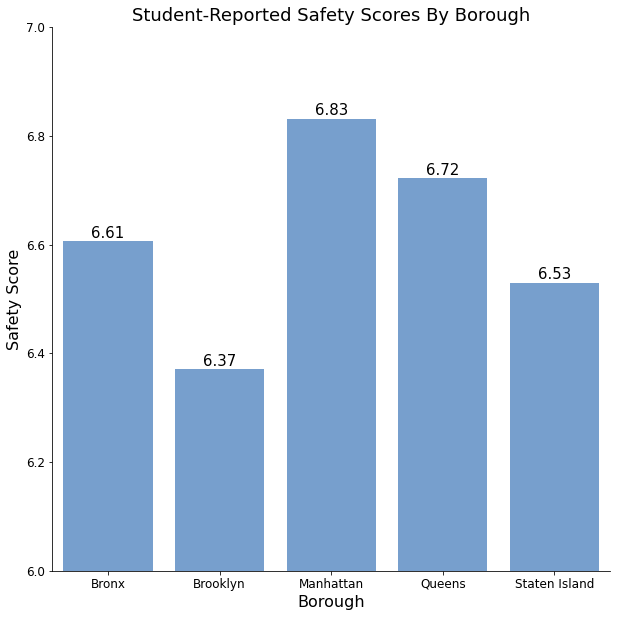

In [37]:
# Group by borough
grouped_boro = combined.groupby(by='boro').agg(np.mean).reset_index()

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
ax=sns.barplot(x='boro', y='saf_s_11', data=grouped_boro, color=[105/255, 158/255, 219/255])
ax.set(ylim=(6, 7))

# Plot Aesthetics
ax.set_title('Student-Reported Safety Scores By Borough', fontsize=18)
ax.set_xlabel('Borough', fontsize=16)
ax.set_ylabel('Safety Score', fontsize=16)
ax.tick_params(labelsize=12)
sns.despine()

# Bar Labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),  
                   (p.get_x() + p.get_width() / 2,  
                    p.get_height()), ha='center', va='center', 
                   size=15, xytext=(0, 8), 
                   textcoords='offset points')

### Observations

Manhattan and Queens have the highest average safety score while Staten Island has the lowest.

## Exploring Race v. SAT Score - Large Disparities Exist

In [38]:
race_cols = [
    'white_per',
    'asian_per', 
    'black_per',
    'hispanic_per']
correlations_race = correlations[race_cols].reset_index()

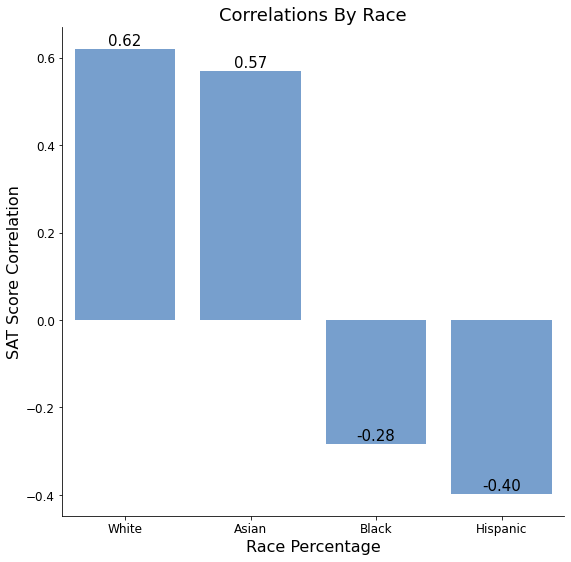

In [39]:
# Plot
fig, ax = plt.subplots(figsize=(9, 9))
ax=sns.barplot(x=race_cols, y='sat_score', data=correlations_race, color=[105/255, 158/255, 219/255])

# Plot Aesthetics
ax.set_title('Correlations By Race', fontsize=18)
ax.set_xlabel('Race Percentage', fontsize=16)
ax.set_ylabel('SAT Score Correlation', fontsize=16)
ax.tick_params(labelsize=12)
ax.set_xticklabels(labels=["White", "Asian", "Black", "Hispanic"])
sns.despine()

# Bar Labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),  
                   (p.get_x() + p.get_width() / 2,  
                    p.get_height()), ha='center', va='center', 
                   size=15, xytext=(0, 8), 
                   textcoords='offset points')

### Observations

The percentage of white and asian students have a positive correlation with SAT score while the percentage of black and hispanic students have a negative correlation with SAT score.  

### Hispanic Percentage v. SAT Score - Language Is A Big Barrier

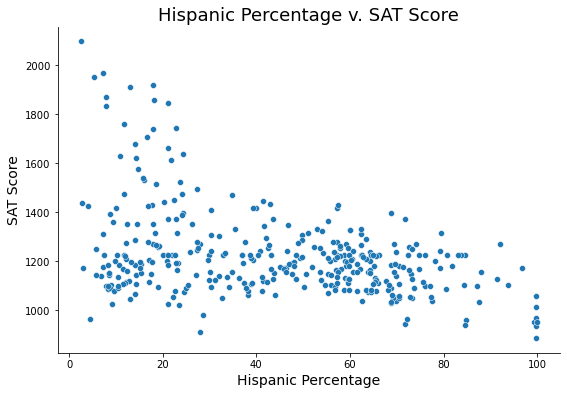

In [40]:
# Plot
fig, ax = plt.subplots(figsize=(9, 6))
ax = sns.scatterplot(data=combined, x='hispanic_per', y='sat_score')

# Plot Aesthetics
ax.set_title('Hispanic Percentage v. SAT Score', fontsize=18)
ax.set_xlabel('Hispanic Percentage', fontsize=14)
ax.set_ylabel('SAT Score', fontsize=14)
sns.despine()

### Observations

Overall as the hispanic percentage increases, the SAT score tends to decrease.  Once hispanic percentage reaches around 25%, there are no schools with SAT scores above about 1500.  For schools with percentages between 25% and around 80%, the SAT score stays within a consistent range of about 1050 to 1400.  There are a handful of schools with percentages near 100

In [41]:
combined[combined['hispanic_per']>95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

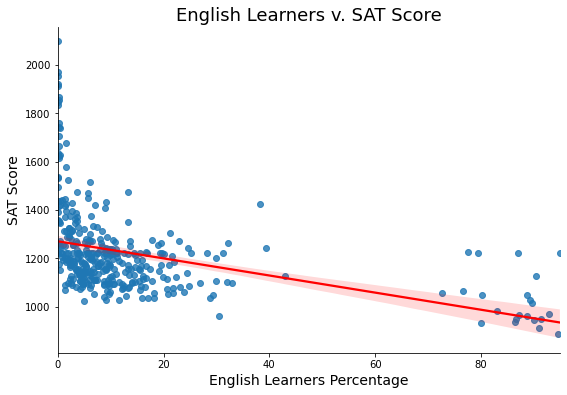

In [42]:
# Plot
fig, ax = plt.subplots(figsize=(9, 6))
ax = sns.regplot(data=combined, x='ell_percent', y='sat_score', line_kws={"color": "red"})

# Plot Aesthetics
ax.set_title('English Learners v. SAT Score', fontsize=18)
ax.set_xlabel('English Learners Percentage', fontsize=14)
ax.set_ylabel('SAT Score', fontsize=14)
sns.despine()

The schools with over 95% hispanic students are international schools where the student body is made up of first generation immigrants from spanish speaking countries where English is their second language.  

The above plot confirms that as the percentage English learners increases, average SAT score at that school decreases.  

This would bolster our earlier observation that English language learner percentage is a big driver of SAT Scores.  

In [43]:
combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools are among the 9 "selective and specialized high schools of New York City" that serve the needs of academically or artistically gifted.  A seperate admissions test is required for enrollment.  As expected, these students do well on the SAT.

## Exploring Gender v. SAT Score  - Not Much Correlation

In [44]:
gender_cols = ['male_per','female_per']
correlations_gender = correlations[gender_cols].reset_index()

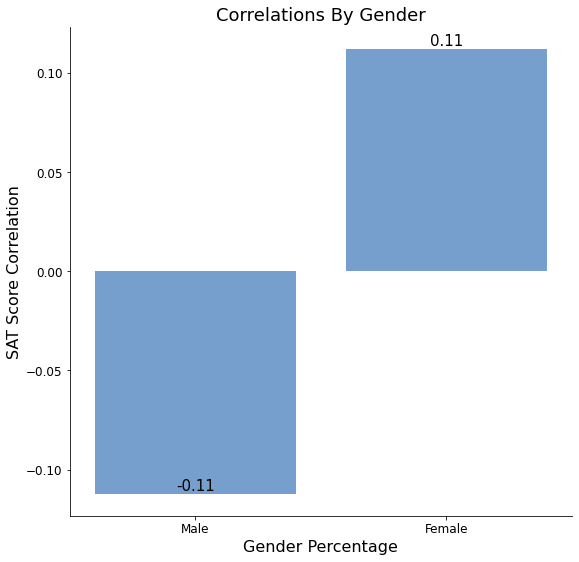

In [45]:
# combined.corr()['sat_score'][['male_per','female_per']].plot.bar()

# Plot
fig, ax = plt.subplots(figsize=(9, 9))
ax=sns.barplot(x=gender_cols, y='sat_score', data=correlations_gender, color=[105/255, 158/255, 219/255])

# Plot Aesthetics
ax.set_title('Correlations By Gender', fontsize=18)
ax.set_xlabel('Gender Percentage', fontsize=16)
ax.set_ylabel('SAT Score Correlation', fontsize=16)
ax.tick_params(labelsize=12)
ax.set_xticklabels(labels=["Male", "Female"])
sns.despine()

# Bar Labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),  
                   (p.get_x() + p.get_width() / 2,  
                    p.get_height()), ha='center', va='center', 
                   size=15, xytext=(0, 8), 
                   textcoords='offset points')

### Observations

Overall there is not much correlation between gender and SAT score.  Higher female percentage has a slightly positive correlation while higher male percentage has a slightly negative correlation.  

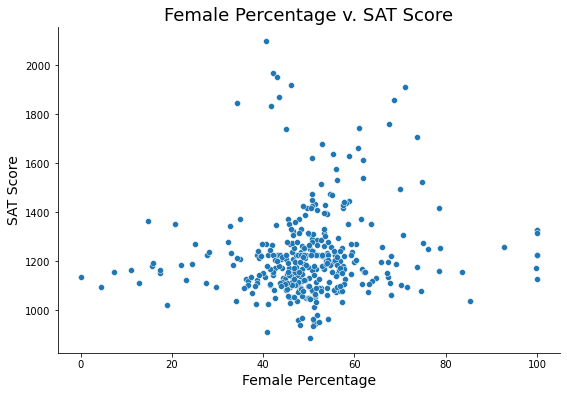

In [46]:
# Plot
fig, ax = plt.subplots(figsize=(9, 6))
ax = sns.scatterplot(data=combined, x='female_per', y='sat_score')

# Plot Aesthetics
ax.set_title('Female Percentage v. SAT Score', fontsize=18)
ax.set_xlabel('Female Percentage', fontsize=14)
ax.set_ylabel('SAT Score', fontsize=14)
sns.despine()

### Observations

There doesnt appear to much correlation between percentage of females and SAT score.  There are some schools with percentages around 40 and 70 that have high SAT scores.  Let's take a closer look at some of those schools:

In [47]:
# Filter schools with high female enrollment and high SAT scores
combined[(combined['female_per'] > 60) & (combined['sat_score'] >1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

### Observations

These schools have a college-prep ciriculum with high adacemic standards.  

## More AP Students Does Not Mean Higher SAT Score

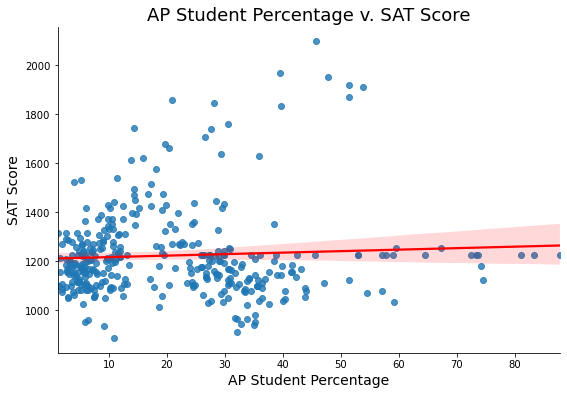

In [48]:
# Create 'ap_per' column to hold the percentage of AP test takers
combined['ap_per'] = (combined['AP Test Takers '] / combined['total_enrollment']) * 100

# Plot
fig, ax = plt.subplots(figsize=(9, 6))
ax = sns.regplot(data=combined, x='ap_per', y='sat_score', line_kws={"color": "red"})

# Plot Aesthetics
ax.set_title('AP Student Percentage v. SAT Score', fontsize=18)
ax.set_xlabel('AP Student Percentage', fontsize=14)
ax.set_ylabel('SAT Score', fontsize=14)
sns.despine()

### Observations

Suprisingly, we see almost no relationship between the amount of AP Students and SAT score.  This may be due to the fact that thereare many AP subjects that do not necessarily match the subect matter of the SAT.  

## Larger Classes Equal Higher SAT Scores

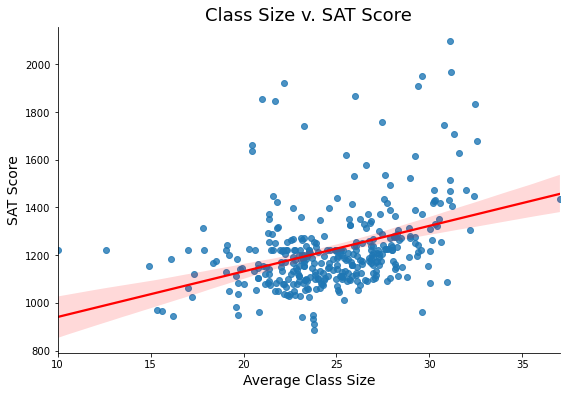

In [49]:
# Plot
fig, ax = plt.subplots(figsize=(9, 6))
ax = sns.regplot(data=combined, x='AVERAGE CLASS SIZE', y='sat_score', line_kws={"color": "red"})

# Plot Aesthetics
ax.set_title('Class Size v. SAT Score', fontsize=18)
ax.set_xlabel('Average Class Size', fontsize=14)
ax.set_ylabel('SAT Score', fontsize=14)
sns.despine()

In [50]:
# Correlation Value
combined['AVERAGE CLASS SIZE'].corr(combined['sat_score'])

0.3810143308095524

### Observations

There is a significant positive correlation between class size and SAT scores.  Usually, one would assume smaller class sizes help students academically since they would receive more attention from the teacher.  Here we are seeing that larger class sizes tend to result in students scoring better on the SAT.

## Which Neighborhoods Have The Best Schools? 

In [51]:
# Filter the Data to only include schools in the top Quartile of SAT Scores
combined_top25 = combined[combined['sat_score'] >= combined['sat_score'].quantile(q=0.75)]
combined_top25 = combined_top25['zip'].value_counts()
combined_top6 = combined_top25.reset_index().head(6)

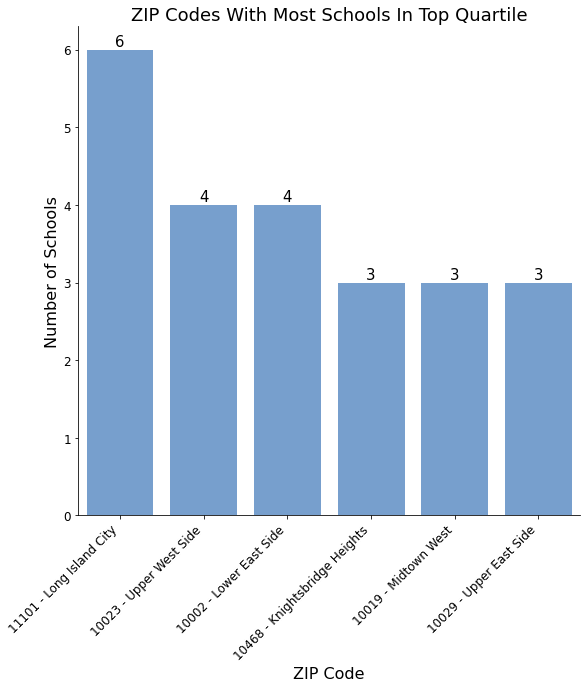

In [52]:
# Create sorted variablel to be passed into 'order' parameter
order = combined_top6.groupby('index')['zip'].sum().sort_values(ascending=False).index.values

# Plot
fig, ax = plt.subplots(figsize=(9, 9))
ax=sns.barplot(x='index', y='zip', data=combined_top6, order=order, color=[105/255, 158/255, 219/255])


# Plot Aesthetics
ax.set_title('ZIP Codes With Most Schools In Top Quartile', fontsize=18)
ax.set_xlabel('ZIP Code', fontsize=16)
ax.set_ylabel('Number of Schools', fontsize=16)
ax.tick_params(labelsize=12)
ax.set_xticklabels(labels=["11101 - Long Island City", "10023 - Upper West Side", "10002 - Lower East Side",
                          "10468 - Knightsbridge Heights", "10019 - Midtown West", "10029 - Upper East Side"],
                           ha="right", rotation=45)
sns.despine()

# Bar Labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),  
                   (p.get_x() + p.get_width() / 2,  
                    p.get_height()), ha='center', va='center', 
                   size=15, xytext=(0, 8), 
                   textcoords='offset points')

In [53]:
combined[survey_fields]

,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,...,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,89.0,70,39,379.000000,26.0,151.0,7.8,7.7,7.4,7.6,...,6.1,6.5,6.000000,5.600000,6.100000,6.700000,6.7,6.2,6.6,7.0
1,84.0,95,10,385.000000,37.0,46.0,7.9,7.4,7.2,7.3,...,6.6,7.3,6.000000,5.700000,6.300000,7.000000,6.8,6.3,6.7,7.2
2,0.0,98,28,598.208333,42.0,150.0,8.7,8.2,8.1,8.4,...,8.0,8.8,6.611667,6.094722,6.620278,7.381389,7.9,7.9,7.9,8.4
3,90.0,100,21,306.000000,29.0,69.0,7.7,7.4,7.2,7.3,...,6.1,6.8,6.400000,5.900000,6.400000,7.000000,6.9,6.2,6.6,7.0
4,98.0,68,51,923.000000,67.0,736.0,8.5,7.9,7.9,8.4,...,5.9,7.3,7.300000,6.400000,7.000000,7.700000,7.8,6.7,6.9,7.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,80.0,57,34,504.000000,28.0,205.0,8.0,7.5,7.5,7.8,...,3.4,4.8,6.400000,5.800000,6.200000,7.000000,6.7,5.2,5.7,6.5
359,73.0,88,41,295.000000,30.0,160.0,8.2,8.1,7.9,8.3,...,8.1,8.5,6.500000,5.900000,6.600000,7.300000,7.3,7.2,7.5,8.1
360,59.0,49,31,256.000000,17.0,127.0,7.9,7.9,7.7,8.0,...,7.0,7.1,6.400000,5.700000,6.700000,7.300000,6.9,6.5,7.1,7.4
361,88.0,81,38,206.000000,13.0,80.0,9.4,8.6,8.5,8.7,...,9.1,9.6,8.900000,7.100000,8.400000,8.900000,9.3,8.1,8.7,9.1


## Investigating Student, Teacher, & Parent Survey Responses

Here we will create a Seaborn catplot so we can easily compare.

In [54]:
# Transform the relevant portion of our data set
combined_survey_melt = pd.melt(combined[survey_fields], value_vars = survey_fields)
combined_survey_melt

,variable,value
0,rr_s,89.0
1,rr_s,84.0
2,rr_s,0.0
3,rr_s,90.0
4,rr_s,98.0
...,...,...
7981,aca_tot_11,6.5
7982,aca_tot_11,8.1
7983,aca_tot_11,7.4
7984,aca_tot_11,9.1


In [55]:
# Define functions that will be used to create new columns
def survey_cat(s):
    if 'saf' in s:
        return "Safety and Respect Score"
    elif 'com' in s:
        return "Communication Score"
    elif 'eng' in s:
        return "Engagement Score"
    elif 'aca' in s:
        return "Academic Score"
    
def respondent_id(s):
    if '_p_' in s:
        return "Parents"
    elif '_s_' in s:
        return "Students"
    elif '_t_' in s:
        return "Teachers"
    elif '_tot_' in s:
        return "Total"

# Create new columns that will be plotted
combined_survey_melt['Respondant'] = combined_survey_melt['variable'].apply(respondent_id)
combined_survey_melt['Survey Category'] = combined_survey_melt['variable'].apply(survey_cat)
combined_survey_melt

,variable,value,Respondant,Survey Category
0,rr_s,89.0,None,None
1,rr_s,84.0,None,None
2,rr_s,0.0,None,None
3,rr_s,90.0,None,None
4,rr_s,98.0,None,None
...,...,...,...,...
7981,aca_tot_11,6.5,Total,Academic Score
7982,aca_tot_11,8.1,Total,Academic Score
7983,aca_tot_11,7.4,Total,Academic Score
7984,aca_tot_11,9.1,Total,Academic Score


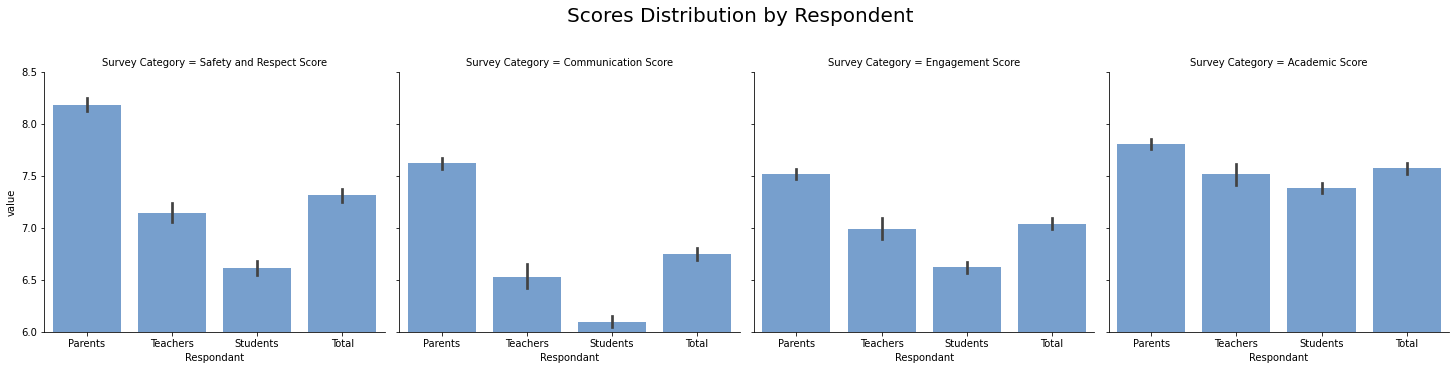

In [56]:
# Plot 
ax = sns.catplot(x='Respondant', y='value', col='Survey Category', data=combined_survey_melt, kind='bar', color=[105/255, 158/255, 219/255])

# Plot Aesthetics
ax.fig.figsize=(20,12)
plt.subplots_adjust(top=.8, hspace=.4)
ax.fig.suptitle('Scores Distribution by Respondent', size=20)
ax.set(ylim=(6, 8.5))

### Observations

All the categories are similar:  Parents rate their child's school more favorably than the teachers or students.  Students tend to rate their schools the least favorable.  This may be because of a disconnect between the parents and the teachers and students.  The parents are not present at school on a daily basis and might be more inclined to thing everything is going great at the school.  

# Conclusions



- __Large racial and language disparities exist.__ Schools with a higher percentage of Black and Hispanic students have a lower SAT score while schools with a larger percentage of White and Asian students have higher SAT scores.  
- __Hispanic students tend to especially worse on the SAT which is due in part to a language barrier.__  NYC has several schools that specialize in first generation students from Spanish-speaking countries.  For these students English is a second language and these schools perform poorly on the SAT.
- __School safety is a big driver of SAT scores.__  Based on the survey data, schools with higher safety scores tend to do better on the SAT.  Schools in Manhattan and Queens have the highest scores while schools in Brooklyn have the lowest on average.  
- Gender makeup of the student body is not a significant factor on SAT scores.
- More Advanced Placement students do not mean higher SAT scores.  This may be due to the fact that there are some AP subects that are not tested on the SAT.  
- Smaller classes do not equal higher SAT score.  
- There is a positive correlation between the total number of students and SAT score
- Long Island City, the Lower East Side, and the Upper West Side have the most top performing schools.

## Methodology Summary

- We took seven data sets of high school and SAT score related data that was provided by the City of New York.  We then combined this data along each school's unique DBN number and then analyzed several metrics against the SAT score.  
- We used the following data analysis techniques:
    - Dataframe joins using concatanation and merge
    - Pandas aggregation using melt, groupby, and apply
    - Extracting strings using Regular Expressions
    - Plotting with Seaborn and Matplotlib including custom aesthetics
    - Pinning schools on a map using the Folium Library
    - Statistical analysis using 'R-Value'
    - Vectorized operations